In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class PatchingAvg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return np.concatenate(self.d).mean(axis=0)

    def std(self):
        return np.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)

In [18]:
def patching_stats(results_dir, kind=None, num_samples=100):
    kindcode = "" if kind is None else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [PatchingAvg() for _ in range(11)]
    for i in range(num_samples):
        file_name = os.path.join(results_dir, 'knowledge_{}{}.npz'.format(i, kindcode))
        if not os.path.exists(file_name):
            continue
        data = np.load(file_name)
        if "scores" not in data:
            continue
        scores = data["scores"]
        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = np.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = np.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", np.argmax(avg_le.avg()))
    print("Max at last subject token", np.max(avg_le.avg()))
    print("Argmax at last prompt token", np.argmax(avg_la.avg()))
    print("Max at last prompt token", np.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )

In [20]:
def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()

Average Total Effect 0.06286957434245516
Best average indirect effect on last subject 0.020825828824724446
Best average indirect effect on last token 0.06823879054614473
Average best-fixed score 0.4360766
Average best-fixed on last subject token score 0.38440445
Average best-fixed on last word score 0.42055684
Argmax at last subject token 21
Max at last subject token 0.3396258
Argmax at last prompt token 45
Max at last prompt token 0.38703877


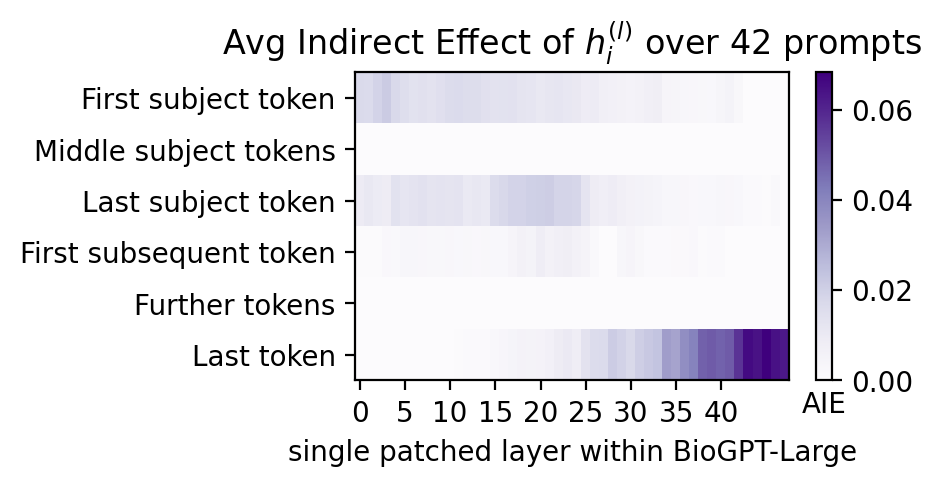

Average Total Effect 0.053493022209122054
Best average indirect effect on last subject 0.009526967292740218
Best average indirect effect on last token 0.030667155271484725
Average best-fixed score 0.4436585
Average best-fixed on last subject token score 0.38328674
Average best-fixed on last word score 0.43192115
Argmax at last subject token 13
Max at last subject token 0.33770353
Argmax at last prompt token 42
Max at last prompt token 0.3588437


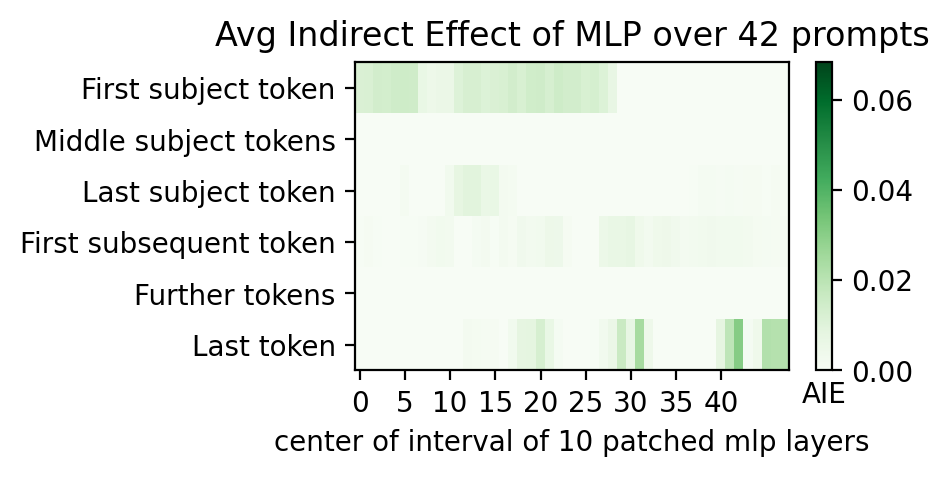

Average Total Effect 0.05372375134556068
Best average indirect effect on last subject 0.00943586114971412
Best average indirect effect on last token 0.04271122697918189
Average best-fixed score 0.42522463
Average best-fixed on last subject token score 0.3625471
Average best-fixed on last word score 0.4200539
Argmax at last subject token 13
Max at last subject token 0.3373817
Argmax at last prompt token 39
Max at last prompt token 0.37065706


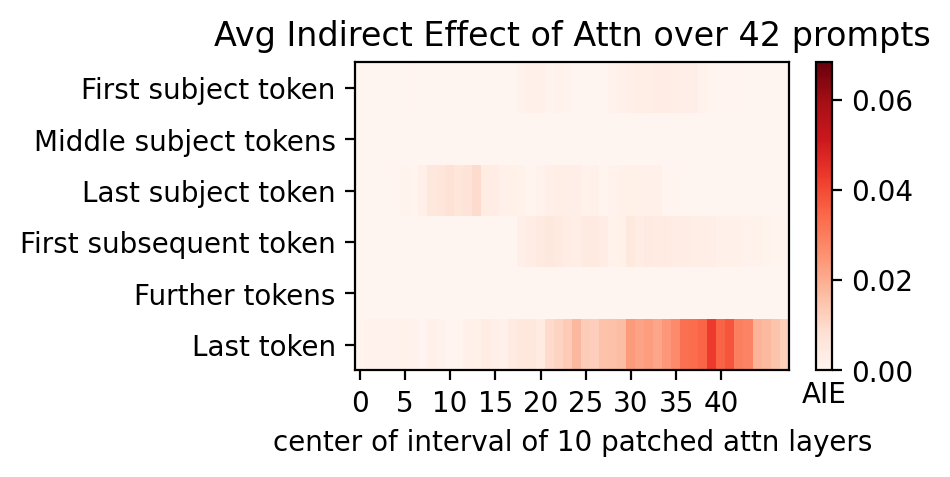

In [ ]:
method = "STR"
# Biogpt Large PubmedQA
#arch = "biogpt-large-pubmedqa"
#archname = "BioGPT-Large-PubMedQA"
#model_name = "microsoft_BioGPT-Large-PubMedQA"

# BioGPT Large
arch = "biogpt-large-base"
archname = "BioGPT-Large"
model_name = "microsoft_BioGPT-Large"
results_dir = f'../../results/{method}_{model_name}/causal_trace/cases/'

for kind in [None, "mlp", "attn"]:
    stats = patching_stats(results_dir, kind=kind)
    count = stats["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind] 
    title = f"Avg {what} over {count} prompts"
    result = np.clip(stats["result"] - stats["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )